In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from os.path import join
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from neuro import analyze_helper, viz
from neuro.features import qa_questions
import pandas as pd

In [ ]:
results_dir = analyze_helper.best_results_dir
rr, cols_varied, mets = analyze_helper.load_clean_results(results_dir)

In [ ]:
r = rr[rr.qa_questions_version.isin(['', 'v3_boostexamples_merged'])]
r = r[r.num_stories == -1]
cols_varied = [c for c in cols_varied if not c in ['num_stories']]

# Check results

In [31]:
d = r
d = d[d.feature_selection_alpha >= 0]
d = d[d.feature_selection_stability_seeds > 0]

In [32]:
print('make sure everything ran both ndelays!')
display(d.ndelays.value_counts())
# d = d[r.distill_model_path.isna()]
# cols_varied = [c for c in cols_varied if not c in [
# 'distill_model_path']]
# d = d[(d.qa_questions_version == 'v1') *
#   (d.qa_embedding_model == 'mistral 7B')]
if len(cols_varied) > 0:
    d = d.groupby(cols_varied)[mets + ['weight_enet_mask_num_nonzero']].mean()
else:
    d = d[mets]

(
    d
    # .sort_values(by='corrs_test_mean', ascending=False)
    .sort_values(by='corrs_tune_pc_mean', ascending=False)
    .rename(columns=lambda x: x.replace('_', ' ').replace('corrs', ''))
    .style
    .background_gradient(cmap='magma', axis=0)
    .format(precision=3)
)
d = d.reset_index()

make sure everything ran both ndelays!


ndelays
8    54
4    27
Name: count, dtype: int64

In [34]:
d = d[~(d.weight_enet_mask_num_nonzero == 54)]

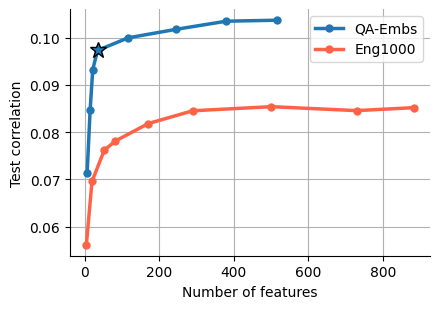

In [45]:
d = d[d.ndelays == 8]
# d = d[d.subject == 'S03']

d['(feature_space, ndelays)'] = list(
    zip(d.feature_space, d.ndelays))
d['feature_space'] = d['feature_space'].map(
    lambda x: {'eng1000': 'Eng1000', 'qa_embedder': 'QA-Embs'}.get(x, x))
plt.figure(figsize=(4.5, 3.2))
ax = sns.lineplot(
    data=d,
    x='weight_enet_mask_num_nonzero',
    y='corrs_test_mean',
    #  hue='(qa_questions_version, ndelays)',
    # hue='(feature_space, ndelays)',
      hue_order=['QA-Embs', 'Eng1000'],
    hue='feature_space',
    # hue='subject',
    palette=['C0', 'tomato'],
    linewidth=2.5,
    markersize=6,
    markeredgewidth=0,
    marker='o',
    err_style=None,
)

# dvu.line_legend()
# plt.title('B', loc=, fontweight='bold')
plt.xlabel('Number of features')
plt.ylabel('Test correlation')

legend = ax.legend()
ax.legend().set_title('')


# get the x,y coords of the first plotted curve
x, y = ax.lines[0].get_data()
plt.plot(x[3], y[3], marker='*', markersize=12, color='C0',
         markeredgewidth=1, markeredgecolor='black')


# logscale x axis
# plt.xscale('log')

# set ylim bottom to 0.1
# plt.ylim(bottom=0.1)
plt.grid()
plt.tight_layout()
plt.savefig('../figs/sparsity.pdf', bbox_inches='tight')
plt.show()

In [27]:
# display full width
with pd.option_context('display.max_colwidth', None):
    display(
        d[d.subject == 'S01']
        .groupby(['feature_space'])
        ['weight_enet_mask_num_nonzero'].unique().reset_index()
    )

,feature_space,weight_enet_mask_num_nonzero
0,Eng1000,"[882.0, 729.0, 501.0, 290.0, 171.0, 83.0, 53.0, 20.0, 5.0]"
1,QA-Embs,"[515.0, 380.0, 246.0, 117.0, 54.0, 35.0, 22.0, 15.0, 7.0]"


# Check sparsity levels

In [ ]:
sparse_feats_dir = join(config.repo_dir, 'sparse_feats')

In [ ]:
!ls {sparse_feats_dir}

In [ ]:
alphas_enet, coefs_enet = joblib.load(
    # join(sparse_feats_dir, 'v1_(0, -3, 15).joblib'))
    join(sparse_feats_dir, 'v3_boostexamples_(0, -3, 15).joblib'))

In [ ]:
for i in range(len(alphas_enet)):
    coef_enet = coefs_enet[:, :, i]
    coef_nonzero = np.any(np.abs(coef_enet) > 0, axis=0)
    print(f'{i=} alpha={alphas_enet[i]:.2e}, n_nonzero={coef_nonzero.sum()}')

### Top questions

In [ ]:
d = r[r.ndelays == 8]
row = d[(d.feature_selection_alpha_index == 3) *
        d.feature_space == 'qa_embedder-10'].iloc[0]

In [ ]:
row[['weights_enet', 'weight_enet_mask', 'weight_enet_mask_num_nonzero']]

In [ ]:
model_params = joblib.load(
    join(row.save_dir_unique, 'model_params.pkl'))

In [ ]:
model_params['weights'].shape

In [ ]:
ndelays = row.ndelays
# weights = model_params['weights']
weights = model_params['weights_pc']
assert weights.shape[0] % ndelays == 0
emb_size = weights.shape[0] / ndelays
weights = weights.reshape(ndelays, int(emb_size), -1)

In [ ]:
weights.shape

In [ ]:
for i in range(29):
    plt.plot(weights[:, i, 4])

In [ ]:
for i in range(29):
    plt.plot(np.abs(weights).mean(axis=-1)[:, i])
plt.xlabel('Delay offset (TRs-1)')
plt.show()

In [ ]:
qs = np.array(qa_questions.get_questions(row.qa_questions_version, full=True))

In [ ]:
mask = row.weight_enet_mask

In [ ]:
qs[mask]

In [ ]:
r['weight_enet_mask']